In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from scipy import interpolate
from sklearn.calibration import LabelEncoder
color = sns.color_palette()

In [ ]:
# train_origin=pd.read_csv("data/round2_train.txt",sep=" ")

# np.random.seed(0)  
# # 按照列的比例随机抽取数据  
# train_sample_ratio = 0.01  # 设置抽样比例为1%  
# train = train_origin.sample(frac=train_sample_ratio, random_state=0)  
  

In [ ]:
# test_a_origin=pd.read_csv("data/round2_ijcai_18_test_a_20180425.txt",sep=" ")
# test_b_origin=pd.read_csv("data/round2_ijcai_18_test_b_20180510.txt",sep=" ")

# np.random.seed(0)  
# # 按照列的比例随机抽取数据  
# test_a_sample_ratio = 0.01  # 设置抽样比例为1%  
# test_a = test_a_origin.sample(frac=test_a_sample_ratio, random_state=0)  

# # 按照列的比例随机抽取数据  
# test_b_sample_ratio = 0.01  # 设置抽样比例为1%  
# test_b = test_b_origin.sample(frac=test_b_sample_ratio, random_state=0)  

In [ ]:
# test = test_a.append(test_b)
# data = pd.concat([train, test])

In [29]:
train=pd.read_csv("data/train_all.csv")
test=pd.read_csv("data/test_all.csv")
data = pd.concat([train, test])

In [30]:
data.shape

(121617, 35)

In [31]:
#原始特征
data.columns.tolist()

['instance_id',
 'item_id',
 'item_category_list',
 'item_property_list',
 'item_brand_id',
 'item_city_id',
 'item_price_level',
 'item_sales_level',
 'item_collected_level',
 'item_pv_level',
 'user_id',
 'user_gender_id',
 'user_age_level',
 'user_occupation_id',
 'user_star_level',
 'context_id',
 'context_timestamp',
 'context_page_id',
 'predict_category_property',
 'shop_id',
 'shop_review_num_level',
 'shop_review_positive_rate',
 'shop_star_level',
 'shop_score_service',
 'shop_score_delivery',
 'shop_score_description',
 'is_trade',
 'time',
 'day',
 'hour',
 'minute',
 'maphour',
 'mapmin',
 'item_category_1',
 'item_category_2']

In [32]:
#初始维度
data.shape

(121617, 35)

In [34]:
#时间数据处理
data['time'] = pd.to_datetime(data.context_timestamp, unit='s')
data['time'] = data['time'].apply(lambda x: x + datetime.timedelta(hours=8)) # 考虑时区，假设是北京时间（UTC+8）  
data['day'] = data['time'].apply(lambda x: int(str(x)[8:10]))
data['hour'] = data['time'].apply(lambda x: int(str(x)[11:13]))   
data['minute'] =  data['time'].apply(lambda x: int(str(x)[14:16]))


In [35]:
#对一天中的不同时间段进行分类或分析。例如，您可能想要跟踪用户在不同时间段内的活动情况，或者根据时间段对某些数据进行分类
def map_hour(s):
    if s < 6:#凌晨时段
        return 1
    elif s < 12:#上午时段
        return 2
    elif s < 18:#下午时段
        return 3
    else:#夜间时段
        return 4

In [36]:
data['maphour'] = data['hour'].map(map_hour)#将一天中的不同小时映射到对应的时间段分类，如早晨、上午、下午和晚上
data['mapmin'] = data['minute'] % 15 + 1#将分钟数划分为 1 到 15 的区间

In [37]:
data_item_category = data.item_category_list.str.split(';', expand=True).add_prefix('item_category_')

for i in range(3):
    data['item_category_'+str(i)] =  data_item_category['item_category_'+str(i)]     
del data['item_category_0']
data['item_category_1'] = data['item_category_1'].apply(int)
data['item_category_2'].fillna(value=0, inplace=True)
data['item_category_2'] = data['item_category_2'].apply(int)

In [38]:
data.columns

Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'time', 'day', 'hour', 'minute',
       'maphour', 'mapmin', 'item_category_1', 'item_category_2'],
      dtype='object')

In [40]:
data.head(5)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,shop_score_description,is_trade,time,day,hour,minute,maphour,mapmin,item_category_1,item_category_2
0,7548377597191725106,9406,836752724084922533;3613783563199627217;1495388...,6241534230954727302;367082587220462692;2072967...,4492,84,8,11,11,17,...,0.978,0.0,2018-09-03 19:13:02,3,19,13,4,14,3613783563199627217,1495388799908940789
1,5975219932893529301,8719,836752724084922533;5685690139879409547;7497531...,6241534230954727302;5131280576272319091;263639...,2821,111,7,9,13,16,...,0.969,0.0,2018-09-06 12:09:32,6,12,9,3,10,5685690139879409547,7497531498747093265
2,7640080258618597885,917,836752724084922533;3613783563199627217;1036082...,5977512434884267894;2636395404473730413;314574...,3812,111,5,10,13,16,...,0.952,0.0,2018-09-03 21:53:39,3,21,53,4,9,3613783563199627217,1036082357054043890
3,3961824130940365274,6764,836752724084922533;1852600517265062354,6241534230954727302;367082587220462692;2072967...,2121,2,7,9,10,18,...,0.985,0.0,2018-08-31 15:25:51,31,15,25,3,11,1852600517265062354,0
4,9169996568220897747,489,836752724084922533;4911723539855588624,6241534230954727302;367082587220462692;5131280...,3474,111,7,11,12,19,...,0.956,1.0,2018-09-01 18:18:47,1,18,18,4,4,4911723539855588624,0


In [41]:
#因为模型通常要求输入为数字形式。标签编码用于将分类变量转换为数字形式，而舍入则用于控制数值特征的精度。
label = ['item_category_1',  'item_category_2', 'context_id',  'item_brand_id', 'item_city_id', 'item_id', 'user_id', 'shop_id']
    
short_label = ['context_page_id', 'shop_star_level', 'user_age_level', 'user_occupation_id', 'user_star_level']

score_label = ['shop_score_service', 'shop_review_positive_rate', 'shop_score_delivery', 'shop_score_description']
    
for col in label:
    col_encoder = LabelEncoder()
    col_encoder.fit(data[col])
    data[col] = col_encoder.transform(data[col])

for col in short_label:
    col_encoder = LabelEncoder()
    col_encoder.fit(data[col])
    data[col] = col_encoder.transform(data[col])

for col in score_label:
    data[col] = round(data[col], 3)

In [42]:
data.head(5)

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,shop_score_description,is_trade,time,day,hour,minute,maphour,mapmin,item_category_1,item_category_2
0,7548377597191725106,9406,836752724084922533;3613783563199627217;1495388...,6241534230954727302;367082587220462692;2072967...,4492,84,8,11,11,17,...,0.978,0.0,2018-09-03 19:13:02,3,19,13,4,14,16,8
1,5975219932893529301,8719,836752724084922533;5685690139879409547;7497531...,6241534230954727302;5131280576272319091;263639...,2821,111,7,9,13,16,...,0.969,0.0,2018-09-06 12:09:32,6,12,9,3,10,19,44
2,7640080258618597885,917,836752724084922533;3613783563199627217;1036082...,5977512434884267894;2636395404473730413;314574...,3812,111,5,10,13,16,...,0.952,0.0,2018-09-03 21:53:39,3,21,53,4,9,16,4
3,3961824130940365274,6764,836752724084922533;1852600517265062354,6241534230954727302;367082587220462692;2072967...,2121,2,7,9,10,18,...,0.985,0.0,2018-08-31 15:25:51,31,15,25,3,11,7,0
4,9169996568220897747,489,836752724084922533;4911723539855588624,6241534230954727302;367082587220462692;5131280...,3474,111,7,11,12,19,...,0.956,1.0,2018-09-01 18:18:47,1,18,18,4,4,17,0


In [44]:
path = './data/'
# 写入
len = train.shape[0]
train_all = data[:len]
test_all = data[len:]


train_all.to_csv(path+'train_all.csv', index=False)
test_all.to_csv(path+'test_all.csv', index=False)



In [45]:
train_all.shape

(104320, 35)

In [46]:
test_all.shape

(17297, 35)

In [51]:
train_all.columns

Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'time', 'day', 'hour', 'minute',
       'maphour', 'mapmin', 'item_category_1', 'item_category_2'],
      dtype='object')

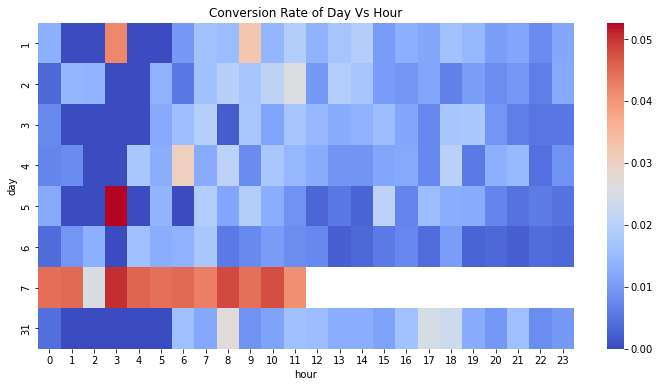

In [52]:
grouped_df = train_all.groupby(["day", "hour"])["is_trade"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'is_trade')
plt.figure(figsize=(12, 6))

sns.heatmap(grouped_df, cmap="coolwarm")  

plt.title("Conversion Rate of Day Vs Hour")
plt.show()

In [58]:
# 查看数据集中的空值
missing_values = train_all.isnull()

# 统计每列的空值数量
missing_count = train_all.isnull().sum()


Missing Values (True if Missing, False if Not):
        instance_id  item_id  item_category_list  item_property_list  \
0             False    False               False               False   
1             False    False               False               False   
2             False    False               False               False   
3             False    False               False               False   
4             False    False               False               False   
...             ...      ...                 ...                 ...   
104315        False    False               False               False   
104316        False    False               False               False   
104317        False    False               False               False   
104318        False    False               False               False   
104319        False    False               False               False   

        item_brand_id  item_city_id  item_price_level  item_sales_level  \
0          

In [ ]:
grouped_df = train_all.groupby(["day", "hour"])["is_trade"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('day', 'hour', 'is_trade')
plt.figure(figsize=(12, 6))

# 通过更改 cmap 参数来调整颜色映射
sns.heatmap(grouped_df, cmap="coolwarm")  # 也可以尝试其他颜色映射，如 "inferno"

plt.title("CVR of Day Vs Hour")
plt.show()

In [ ]:
# # 写文件
# def write_xlsx(df,path, sheetName):
#     writer = pd.ExcelWriter(path, engine='openpyxl',mode='a', if_sheet_exists="overlay")
#     df.to_excel(writer, sheet_name=sheetName)
#     writer.close()
# # 写入同一个文件三张表
# path = '../data_all.xlsx'
# pd.DataFrame().to_excel(path,sheet_name='total') # 先创建文件
# write_xlsx(train,path,'train')
# write_xlsx(test_a, path,'test_a')
# write_xlsx(test_b,path,'test_b')